In [2]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [20]:
#channel_PIPS_trans = "SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
#channel_Izero = "SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
#channel_Izero2 = "SARES11-LSCP10-FNS:CH0:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
#channel_Izero3 = "SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
#channel_Izero4 = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
#channel_LaserDiode = "SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
#channel_Laser_refDiode = "SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
#channel_pulse_ids = "SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
#channel_delay = "SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
#channel_LAM_delaystage = "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
#channel_LAM_stepper = "SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
#channel_PALM_eTOF = "SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2

#Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
#channel_position = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 

In [3]:
channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray TRANS diode to PRIME Keysight (channel 1)
channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"            #X-ray FLUO diode to PRIME Keysight (channel 2)
channel_Izero2 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_pulse_ids = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)

channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
channel_PALM_drift = "data/SAROP11-PALMK118:CH2_VAL_GET/data"               #PALM drift
channel_position = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"     #Energy from the mono

In [37]:
scan_name ="Febpy_jetx_mono_003"

# file names of the type below. copy paste for ease:
# FEL_knife_edge_Y_coarse_
# FEL_knife_edge_X_coarse_
# FEL_knife_edge_Y_fine_
# FEL_knife_edge_X_fine_

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

In [38]:
def LoadData_knife_edge(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Data = BS_file[channel_PIPS_fluo][:][reprate_FEL]
        DataT = BS_file[channel_PIPS_trans][:][reprate_FEL]
        DataLaser = BS_file[channel_LaserDiode][:][reprate_laser]
        
        Izero = BS_file[channel_Izero][:][reprate_FEL]
        Position = BS_file[channel_position][:][reprate_FEL]
        
    return Data, DataT, DataLaser, Izero, Position

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [39]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 31G
-rw-r--r--.   1 root p17803 1.8G Jan 31 13:46 Febpy_jetx_mono_003_step0000.JF02T09V01.h5
drwxrwsr-x. 142 root p17803  32K Jan 31 13:46 ..
-rw-r--r--.   1 root p17803 1.8G Jan 31 13:46 Febpy_jetx_mono_003_step0001.JF02T09V01.h5
-rw-r--r--.   1 root p17803 734K Jan 31 13:46 Febpy_jetx_mono_003_step0000.BSREAD_CA.h5
-rw-r--r--.   1 root p17803 1.8G Jan 31 13:47 Febpy_jetx_mono_003_step0002.JF02T09V01.h5
-rw-r--r--.   1 root p17803 756K Jan 31 13:47 Febpy_jetx_mono_003_step0001.BSREAD_CA.h5
-rw-r--r--.   1 root p17803 1.8G Jan 31 13:47 Febpy_jetx_mono_003_step0003.JF02T09V01.h5
-rw-r--r--.   1 root p17803 726K Jan 31 13:47 Febpy_jetx_mono_003_step0002.BSREAD_CA.h5
-rw-r--r--.   1 root p17803  83M Jan 31 13:47 Febpy_jetx_mono_003_step0000.BSREAD.h5
-rw-r--r--.   1 root p17803 575K Jan 31 13:47 Febpy_jetx_mono_003_step0003.BSREAD_CA.h5
-rw-r--r--.   1 root p17803 1.8G Jan 31 13:47 Febpy_jetx_mono_003_step0004.JF02T09V01.h5
-rw-r--r--.   1 root p17803  83M Jan 31 13:47 Febpy_jetx_mo

In [40]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal = []
SignalT = []
SignalLaser = []
err_signal = []

Izero = []
err_Izero = []

Position_mm = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    exists = os.path.isfile(filename)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (signal_loop,signalT_loop,signalLaser_loop,Izero_loop,position_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
        Signal.append(signal_loop.mean())
        SignalT.append(signalT_loop.mean())
        SignalLaser.append(signalLaser_loop.mean())
        err_signal.append(signal_loop.std()/np.sqrt(signal_loop.size))
        Izero.append(Izero_loop.mean())
        err_Izero.append(Izero_loop.std()/np.sqrt(Izero_loop.size))
    
        position_loop = [x for x in position_loop if (np.abs(x) > 0)]
        Position_mm.append(np.mean(position_loop))
    #Position_mm.append(position_loop[0])
    
Signal = np.asarray(Signal)
SignalT = np.asarray(SignalT)
SignalLaser = np.asarray(SignalLaser)

err_signal = np.asarray(err_signal)
Izero = np.asarray(Izero)
err_Izero = np.asarray(err_Izero)

Position_mm = np.asarray(Position_mm)
print ("Job done!")

/sf/alvra/data/p17803/res/scan_info/Febpy_jetx_mono_003_scan_info.json
Processing 17 files
step 1 of 17 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_jetx_mono_003/Febpy_jetx_mono_003_step0000.BSREAD.h5
step 2 of 17 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_jetx_mono_003/Febpy_jetx_mono_003_step0001.BSREAD.h5
step 3 of 17 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_jetx_mono_003/Febpy_jetx_mono_003_step0002.BSREAD.h5
step 4 of 17 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_jetx_mono_003/Febpy_jetx_mono_003_step0003.BSREAD.h5
step 5 of 17 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_jetx_mono_003/Febpy_jetx_mono_003_step0004.BSREAD.h5
step 6 of 17 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_jetx_mono_003/Febpy_jetx_mono_003_step0005.BSREAD.h5
step 7 of 17 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_jetx_mono_003/Febpy_jetx_mono_003_step0006.BSREAD.h5
step 8 of 17 : Processing /sf/alvra/data/p17803/raw/scan_data/

In [41]:
# We are not normalizing now because the 117 and the 122 are out of the way.

Signal_norm = Signal / Izero
SignalT_norm = SignalT / Izero

err_signal_norm = err_signal / Izero

<IPython.core.display.Javascript object>


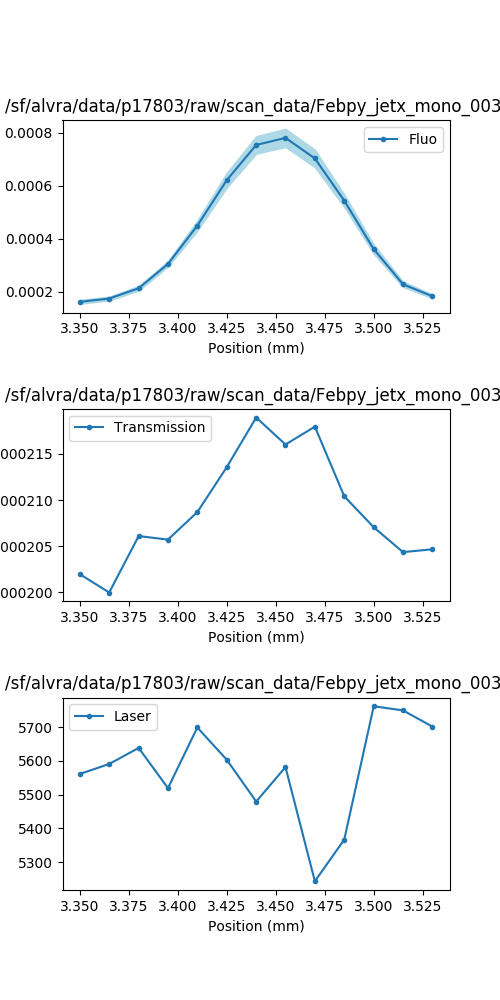

In [42]:
plt.figure(figsize = (5,10))
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)

plt.plot(Position_mm, Signal_norm, label="Fluo",marker='.')
low_err= Signal_norm - err_signal_norm
high_err= Signal_norm + err_signal_norm
plt.fill_between(Position_mm, low_err, high_err, color='lightblue')
plt.title(DIR)
plt.xlabel("Position (mm)")
plt.legend(loc="best")

plt.subplot(312)
plt.plot(Position_mm, SignalT_norm, label="Transmission",marker='.')
#low_err= Signal_norm - err_signal_norm
#high_err= Signal_norm + err_signal_norm
#plt.fill_between(Position_mm, low_err, high_err, color='lightblue')
plt.title(DIR)
plt.xlabel("Position (mm)")
plt.legend(loc="best")

plt.subplot(313)
plt.plot(Position_mm, SignalLaser, label="Laser",marker='.')
#low_err= Signal_norm - err_signal_norm
#high_err= Signal_norm + err_signal_norm
#plt.fill_between(Position_mm, low_err, high_err, color='lightblue')
plt.title(DIR)
plt.xlabel("Position (mm)")
plt.legend(loc="best")


plt.show()
#plt.savefig('Timescan_7_diode')

In [36]:
# Now fit with error function (defined above)
parameters,extras = curve_fit(errfunc, Position_mm, Signal_norm, p0 = [0, 0.1, 16.9, 0.05]) # [baseline, step amplitude, center, FWHM]

print("Position t0 =",np.abs(np.round(parameters[2],3)),"mm")
print("Width =",np.abs(np.round(parameters[3],3)),"mm")

Position t0 = 16.9 mm
Width = 0.05 mm


/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


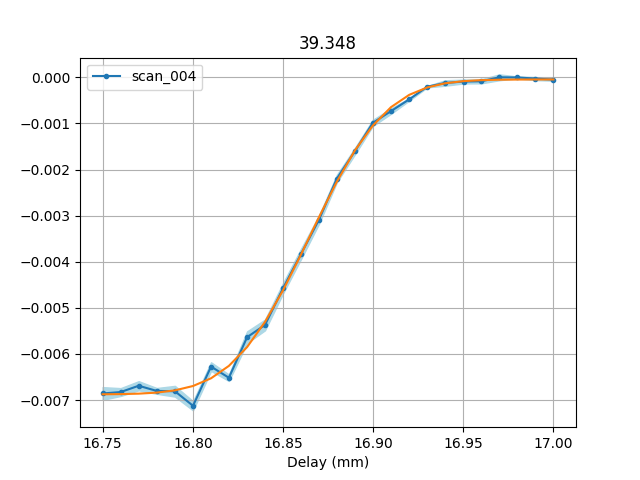

In [195]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Position_mm, Signal_norm, label="scan_004",marker='.')
plt.plot(Position_mm, errfunc(Position_mm,*parameters))

low_err= Signal_norm - err_signal_norm
high_err= Signal_norm + err_signal_norm
plt.fill_between(Position_mm, low_err, high_err, color='lightblue')

plt.title(np.round(parameters[3]*1000, 3) )
plt.grid()
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_LAM_003')